In [ ]:
% pylab inline
from numpy import linalg as LA
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob
from tqdm import tqdm_notebook
import os
import sklearn.preprocessing as prep
import pickle
import joblib
import tensorflow as tf

def min_max_scale(X):
    preprocessor = prep.MinMaxScaler().fit(X)
    X_scaled = preprocessor.transform(X)
    return X_scaled

In [ ]:
master_matrix = joblib.load('../scripts/tumor_and_normal_200000_standardized_X.joblib.pickle')
y = joblib.load('../scripts/tumor_and_normal_200000_standardized_y.joblib.pickle')


In [ ]:
master_matrix.shape

In [95]:
y.shape

(10000,)

In [22]:
WIDTH = 256 
HEIGHT = 256
DEPTH = 3

def standardize_image(f):
    standardized = (imread(f) / 255.0).reshape(-1, 256 * 256 * 3)
    return standardized

In [5]:
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
config.gpu_options.allocator_type = 'BFC'
#config

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3


class VAE(object):
    def __init__(self,
                 input_dim,
                 learning_rate=0.001,
                 n_latent=100,
                 batch_size=50):
        self.learning_rate = learning_rate
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.input_dim = input_dim

        self._build_network()
        self._create_loss_optimizer()

        init = tf.global_variables_initializer()
        #init = tf.initialize_all_variables()
        # Launch the session
        self.session = tf.InteractiveSession(config=config)
        self.session.run(init)
        self.saver = tf.train.Saver(tf.all_variables())

    def _build_network(self):
        self.x = tf.placeholder(tf.float32, [None, self.input_dim])
        dense1 = tf.layers.dense(
            activation=tf.nn.elu, inputs=self.x, units=512)
        dense2 = tf.layers.dense(
            activation=tf.nn.elu, inputs=dense1, units=512)
        dense3 = tf.layers.dense(
            activation=tf.nn.elu, inputs=dense2, units=512)
        dense4 = tf.layers.dense(
            activation=None, inputs=dense3, units=self.n_latent * 2)
        self.mu = dense4[:, :self.n_latent]
        self.sigma = tf.nn.softplus(dense4[:, self.n_latent:])
        eps = tf.random_normal(
            shape=tf.shape(self.sigma), mean=0, stddev=1, dtype=tf.float32)
        self.z = self.mu + self.sigma * eps

        ddense1 = tf.layers.dense(
            activation=tf.nn.elu, inputs=self.z, units=512)
        ddense2 = tf.layers.dense(
            activation=tf.nn.elu, inputs=ddense1, units=512)
        ddense3 = tf.layers.dense(
            activation=tf.nn.elu, inputs=ddense2, units=512)

        self.reconstructed = tf.layers.dense(
            activation=tf.nn.sigmoid, inputs=ddense3, units=self.input_dim)

    def _create_loss_optimizer(self):
        epsilon = 1e-10
        reconstruction_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon + self.reconstructed) +
            (1 - self.x) * tf.log(epsilon + 1 - self.reconstructed),
            axis=1)

        self.reconstruction_loss = tf.reduce_mean(
            reconstruction_loss) / self.batch_size

        latent_loss = -0.5 * tf.reduce_sum(
            1 + tf.log(epsilon + self.sigma) - tf.square(self.mu) - tf.square(
                self.sigma),
            axis=1)
        latent_loss = tf.reduce_mean(latent_loss) / self.batch_size
        self.latent_loss = latent_loss
        self.cost = tf.reduce_mean(self.reconstruction_loss + self.latent_loss)
        # ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.cost)

    def fit_minibatch(self, batch):
        _, cost, reconstruction_loss, latent_loss = self.session.run(
            [
                self.optimizer, self.cost, self.reconstruction_loss,
                self.latent_loss
            ],
            feed_dict={self.x: batch})
        return cost, reconstruction_loss, latent_loss

    def reconstruct(self, x):
        return self.session.run([self.reconstructed], feed_dict={self.x: x})

    def decoder(self, z):
        return self.session.run([self.reconstructed], feed_dict={self.z: z})

    def encoder(self, x):
        return self.session.run([self.z], feed_dict={self.x: x})

    def save_model(self, checkpoint_path, epoch):
        self.saver.save(self.session, checkpoint_path, global_step=epoch)

    def load_model(self, checkpoint_dir):
        #new_saver = tf.train.import_meta_graph(checkpoint_path)
        #new_saver.restore(sess, tf.train.latest_checkpoint('./'))

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir=checkpoint_dir, latest_filename='checkpoint')
        print('loading model: {}'.format(ckpt.model_checkpoint_path))
        self.saver.restore(self.session, ckpt.model_checkpoint_path)
        
    

In [10]:
learning_rate=1e-4
batch_size=32
num_epoch=1000
n_latent=100
    
checkpoint_dir = '/Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000_nlatent100'   
os.makedirs(checkpoint_dir, exist_ok=True)
input_dim = IMAGE_CHANNELS*IMAGE_WIDTH*IMAGE_HEIGHT
tf.reset_default_graph()
#input_dims = input_dim[1]
model = VAE(input_dim=input_dim,
            learning_rate=learning_rate,
            n_latent=n_latent,
            batch_size=batch_size)
model.load_model(checkpoint_dir)

/home/saket/anaconda3/lib/python3.5/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


loading model: /Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000_nlatent100/model.ckpt-995-995
INFO:tensorflow:Restoring parameters from /Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000_nlatent100/model.ckpt-995-995


Populating the interactive namespace from numpy and matplotlib


/home/saket/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


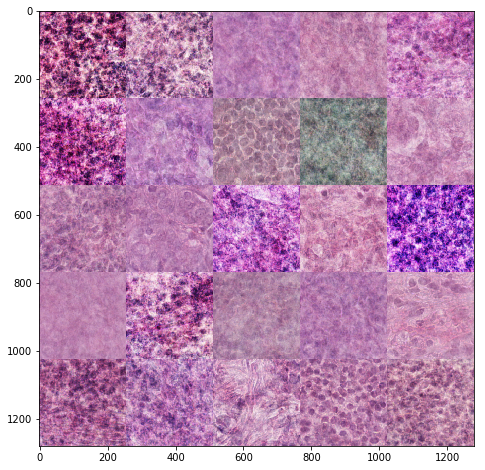

In [11]:
# Test the trained model: generation
%pylab inline
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_latent])
x_generated = model.decoder(z)[0]

w = h = 256 
n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n, 3))

for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w, :] = x_generated[i*n+j, :].reshape(w, h, 3)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated)# cmap='gray')


In [12]:
master_matrix[0].reshape()

array([[0.73333333, 0.64313725, 0.70588235, ..., 0.46666667, 0.27843137,
        0.50588235]])

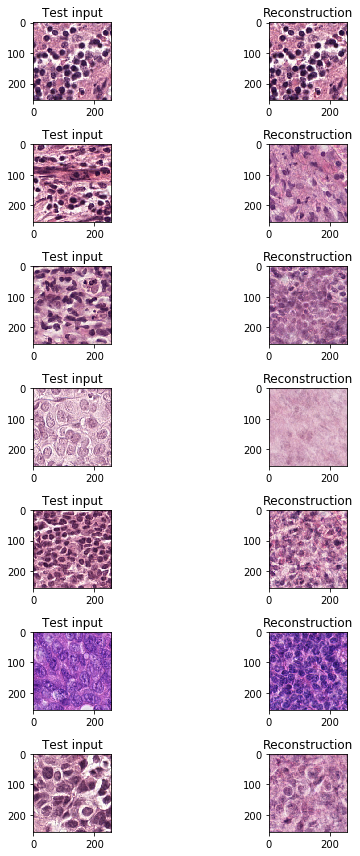

In [20]:

x_sample = np.reshape(master_matrix, (-1, 256*256*3))
x_encoded =  model.encoder(x_sample)
x_reconstruct = model.reconstruct(x_sample)


plt.figure(figsize=(8, 12))
for i in range(7):

    plt.subplot(7, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(256, 256, 3))
    plt.title("Test input")
    #plt.colorbar()
    plt.subplot(7, 2, 2*i + 2)
    plt.imshow(x_reconstruct[0][i].reshape(256, 256, 3))
    plt.title("Reconstruction")
    #plt.colorbar()
plt.tight_layout()

In [16]:
x_reconstruct[0].shape

(10000, 196608)

In [21]:
x_encoded[0].shape

(10000, 100)

# Train a TPOT on these reduced dimension!

In [65]:
test_tumor_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/test_tumor_level0/level_0/'
list_of_tumor_files = list(glob.glob('{}*.png'.format(test_tumor_patches_dir)))

test_normal_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/test_normal_level0/level_0/'
list_of_normal_files = list(glob.glob('{}*.png'.format(test_normal_patches_dir)))



In [27]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(x_encoded[0], y,
                                                    train_size=0.75, test_size=0.25)

pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_valid, y_valid))
pipeline_optimizer.export('tpot_exported_pipeline_autoencoder_nlatent100.py')

Optimization Progress:  34%|███▍      | 41/120 [21:29<25:20, 19.24s/pipeline]

Generation 1 - Current best internal CV score: 0.6626647696584161


Optimization Progress:  52%|█████▎    | 63/120 [35:17<1:35:36, 100.65s/pipeline]

Generation 2 - Current best internal CV score: 0.6647954370350091


Optimization Progress:  69%|██████▉   | 83/120 [43:08<14:57, 24.25s/pipeline]

Generation 3 - Current best internal CV score: 0.6647954370350091


Optimization Progress:  87%|████████▋ | 104/120 [54:58<05:17, 19.83s/pipeline]

Generation 4 - Current best internal CV score: 0.665061303879098


Generation 5 - Current best internal CV score: 0.665061303879098

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=79, p=2, weights=distance)
0.6624


True

In [66]:
y_test = []
X_test_matrix = []
for f in tqdm_notebook(list_of_tumor_files):
    standardized = (imread(f)).reshape(-1, 256 * 256 * 3)
    X_test_matrix.append(standardized)    
    y_test.append(1)

for f in tqdm_notebook(list_of_normal_files):
    standardized = (imread(f)).reshape(-1, 256 * 256 * 3)
    X_test_matrix.append(standardized)    
    y_test.append(0)



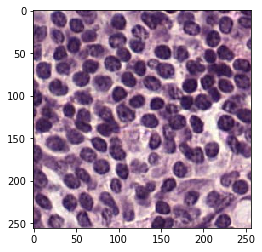

In [67]:
plt.imshow(X_test_matrix[0].reshape( 256 , 256 , 3))

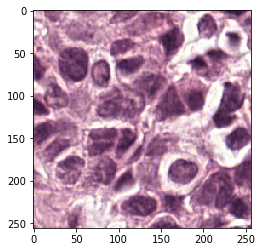

In [68]:
plt.imshow(x_sample[i].reshape(256, 256, 3))

In [69]:
x_sample[i]

array([0.96078431, 0.81176471, 0.87058824, ..., 0.42352941, 0.25098039,
       0.38823529])

In [70]:
X_test_matrix[0]

array([[0.7137255 , 0.6       , 0.6862745 , ..., 0.84313726, 0.69411767,
        0.7764706 ]], dtype=float32)

In [71]:
X_test_matrix = np.array(X_test_matrix)
y_test = np.array(y_test)
x_test_input = np.reshape(X_test_matrix, (-1, 256*256*3))
x_test_encoded = model.encoder(x_test_input)[0]
print(pipeline_optimizer.score(x_test_encoded, y_test))

0.2510897277736656


In [72]:
x_test_reconstructed = model.reconstruct(x_test_input)[0]


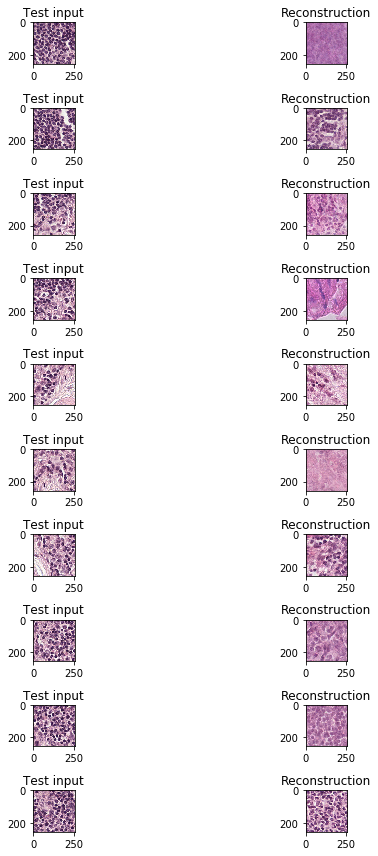

In [79]:
plt.figure(figsize=(10, 12))
for i in range(10):

    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(x_test_input[i].reshape(256, 256, 3))
    plt.title("Test input")
    #plt.colorbar()
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(x_test_reconstructed[i].reshape(256, 256, 3))
    plt.title("Reconstruction")
    #plt.colorbar()
plt.tight_layout()

# lightgbm

In [81]:
import json
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


In [93]:
X_train.shape

(7500, 100)

In [82]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

Start training...
[1]	valid_0's auc: 0.670349	valid_0's l2: 0.247113
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.690909	valid_0's l2: 0.244348
[3]	valid_0's auc: 0.690114	valid_0's l2: 0.242079
[4]	valid_0's auc: 0.691787	valid_0's l2: 0.239857
[5]	valid_0's auc: 0.698113	valid_0's l2: 0.237682
[6]	valid_0's auc: 0.703645	valid_0's l2: 0.235556
[7]	valid_0's auc: 0.706232	valid_0's l2: 0.233819
[8]	valid_0's auc: 0.708454	valid_0's l2: 0.232098
[9]	valid_0's auc: 0.71153	valid_0's l2: 0.230343
[10]	valid_0's auc: 0.711498	valid_0's l2: 0.229012
[11]	valid_0's auc: 0.711947	valid_0's l2: 0.227723
[12]	valid_0's auc: 0.71308	valid_0's l2: 0.226502
[13]	valid_0's auc: 0.716049	valid_0's l2: 0.225026
[14]	valid_0's auc: 0.717202	valid_0's l2: 0.22391
[15]	valid_0's auc: 0.718642	valid_0's l2: 0.222839
[16]	valid_0's auc: 0.719611	valid_0's l2: 0.221906
[17]	valid_0's auc: 0.720232	valid_0's l2: 0.221069
[18]	valid_0's auc: 0.7211	valid_0's l2: 0.22025


In [101]:
x_test_encoded.shape

(12159, 100)

In [102]:
x_test_input.shape

(12159, 196608)

In [96]:
y_pred_test_gbm = gbm.predict(x_test_input, num_iteration=gbm.best_iteration)


In [97]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred_test_gbm) ** 0.5)


The rmse of prediction is: 0.615108940208416


In [98]:
y_pred_test_gbm_bin = [1 if x>0.5 else 0 for x in y_pred_test_gbm]

In [99]:
from sklearn.metrics import accuracy_score

In [100]:
accuracy_score(y_pred_test_gbm_bin, y_test )

0.22625215889464595

In [ ]:
gbm.feature_importance()

In [ ]:
features = pd.